In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip install torch torchvision

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fcb386a4c88>: Failed to establish a new connection: [Errno 101] Network is unreachable',)': /packages/69/43/380514bd9663f1bf708abeb359b8b48d3fabb1c8e95bb3427a980a064c57/torch-0.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fcb386a4898>: Failed to establish a new connection: [Errno 101] Network is unreachable',)': /packages/69/43/380514bd9663f1bf708abeb359b8b48d3fabb1c8e95bb3427a980a064c57/torch-0.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSCo

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable

ModuleNotFoundError: ignored

## Load data

In [0]:
train_dataset = datasets.MNIST(root='~/Download/', train=True, transform=transforms.ToTensor(), download=True)
print('Length of train dataset'.format(len(train_dataset)))
test_dataset = datasets.MNIST(root='~/Download/', train=False, transform=transforms.ToTensor(), download=True)
print('Length of test dataset'.format(len(test_dataset)))
print('Shape of each image: {}'.format(train_dataset[0][0].size()))

Length of train dataset
Length of test dataset
Shape of each image: torch.Size([1, 28, 28])


## Display MNIST

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Text(0.5,1,'5')

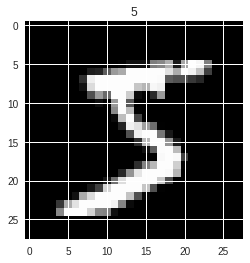

In [0]:
shape = list(train_dataset[0][0].size()[-2:])
show_img = train_dataset[0][0].numpy().reshape(shape)
plt.imshow(show_img, cmap='gray')
plt.title(train_dataset[0][1].numpy())

## Make dataset iterable

In [0]:
batch_size = 100
n_iters = 6000
n_epochs = int(n_iters / (len(train_dataset)/batch_size))

print('Number of epochs: {}'.format(n_epochs))


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Number of epochs: 10


### Check iterability

In [0]:
import collections
isinstance(train_loader, collections.Iterable)
isinstance(test_loader, collections.Iterable)

True

## Build model

In [0]:
class RNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)       
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=128*7*7, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        
        
            
                
    def forward(self, x):
        
        out = self.cnn1(x)            # 16x28x28
        out = self.relu(out)            # 16x28x28        
        out = self.cnn2(out)            # 32x28x28
        out = self.relu(out)            # 32x28x28
        out = self.maxpool(out)         # 32x14x14
        out = self.cnn3(out)            # 64x14x14
        out = self.relu(out)            # 64x14x14
        out = self.cnn4(out)            # 128x14x14
        out = self.relu(out)            # 128x14x14
        out = self.maxpool(out)         # 128x7x7
        out = out.view(out.size(0), -1) # 1x(128*7*7)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

## Instatiate model

In [0]:
ann = CNN()
if torch.cuda.is_available():
  ann.cuda()

## Instantiate loss class

In [0]:
criterion = nn.CrossEntropyLoss()

## model.parameters() explained

In [0]:
print(ann.parameters())
print(len(list(ann.parameters())))

for parameter in list(ann.parameters()):
    print(parameter.size())

<generator object Module.parameters at 0x7fcd8ef524c0>
12
torch.Size([16, 1, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([500, 6272])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


## Optimizer

In [0]:
learning_rate = 0.1
optimizer = torch.optim.SGD(ann.parameters(), lr=learning_rate)

## Training phase

In [0]:
iteration = 0
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
          images = Variable(images.cuda())
          labels = Variable(labels.cuda())
        else:
          images = Variable(images)
          labels = Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = ann(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        iteration += 1
        
        if iteration%500 == 0:
            correct = 0
            total = 0
            
            for images, labels in test_loader:
                if torch.cuda.is_available():
                  images = Variable(images.cuda())
                  labels = Variable(labels.cuda())
                else:
                  images = Variable(images)
                  labels = Variable(labels)
                
                outputs = ann(images)
                
                predicted = torch.argmax(outputs, dim=1)
                
                total += labels.size()[0]
                
                correct += (predicted == labels).sum()
                
                
            accuracy = 100*correct/total
            
            print('Epoch: {}, Iteration: {}, Loss: {}, Accuracy: {}%'.format(epoch, iteration, loss, accuracy))
                            

Epoch: 0, Iteration: 500, Loss: 0.04327140748500824, Accuracy: 98%
Epoch: 1, Iteration: 1000, Loss: 0.03309674561023712, Accuracy: 98%
Epoch: 2, Iteration: 1500, Loss: 0.05346955358982086, Accuracy: 98%
Epoch: 3, Iteration: 2000, Loss: 0.016049513593316078, Accuracy: 98%
Epoch: 4, Iteration: 2500, Loss: 0.007302818354219198, Accuracy: 98%
Epoch: 4, Iteration: 3000, Loss: 0.054626259952783585, Accuracy: 98%
Epoch: 5, Iteration: 3500, Loss: 0.011208572424948215, Accuracy: 98%
Epoch: 6, Iteration: 4000, Loss: 0.0008606862975284457, Accuracy: 99%
Epoch: 7, Iteration: 4500, Loss: 0.03612092137336731, Accuracy: 98%
Epoch: 8, Iteration: 5000, Loss: 0.003456277772784233, Accuracy: 99%
Epoch: 9, Iteration: 5500, Loss: 0.004914288409054279, Accuracy: 99%
Epoch: 9, Iteration: 6000, Loss: 0.011872291564941406, Accuracy: 98%


## Show test images

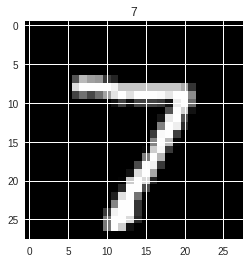

In [0]:
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    labels = Variable(labels)
    
    plt.imshow(images[0].view(28,28).numpy(), cmap='gray')
    plt.title(labels[0].numpy())
    
    break